# Machine learning methods for predicting microbial community dynamics

1) for test   
2) input data: environmental variables, output: asv abundance   
3) model used: dummy, linear regression, Ridge regresion, PCR, PLS, random forest, a self-defined linear regression.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np

## Models 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel


## self models
from scipy.optimize import minimize
from joblib import Parallel
from sklearn.utils.fixes import delayed


In [2]:
## read files
os.chdir("D:\\PhD\\research\\project\\DARPA_predict dynamics\\data analysis\\test")  # set dir location
env=pd.read_csv('NormanA.Env.fillna.csv')
asv=pd.read_csv('NormanA.ASV.Top5.csv') ## or read top 100 asv files
envnp=env[env.columns[1:]].to_numpy(dtype='float32')
asvnp=asv[asv.columns[1:]].to_numpy(dtype='float32').T
outpath='top5_predicted/'

In [3]:
asv

,ASVID,N02A,N03A,N04A,N05A,N06A,N07A,N08A,N09A,N10A,...,N43A,N44A,N45A,N46A,N47A,N48A,N49A,N50A,N51A,N52A
0,99fee0a19b008f861969600865c985de,337,506,598,947,306,1437,2042,1643,554,...,4488,5525,8401,5281,5864,3177,6861,1751,1103,737
1,c834e02be94ea60ec2900976677cc474,1276,1733,3439,3774,867,3005,2857,1319,602,...,2313,1904,906,505,554,620,693,1980,2008,1594
2,123e950130b49f3692b2898d9a43ef9c,108,99,119,126,20,150,275,256,392,...,988,984,750,466,396,290,502,618,631,886
3,dfcfd742612d616e7c1097c359c7e63b,1075,1744,1498,1476,357,1130,609,1242,1376,...,558,267,56,0,0,0,39,0,0,0
4,091126efa2a5f6896c1a128c49160228,558,460,434,253,81,404,629,595,658,...,188,188,114,123,62,41,143,22,94,140


## Define functions

In [4]:
## Define user functions
def split_samples(data,train_size,test_size):
    """ split samples for test (later) and train (former) samples"""
    train=data[(len(data)-test_size-train_size):(len(data)-test_size),:]
    test=data[(len(data)-test_size):,:]
    return train,test
    

def geo_mean_overflow(iterable):
    """calculated geometric mean"""
    
    return np.exp(np.log(iterable).mean(axis=1))


## Could be a problem adding 0.01 when the data strucutre is very sparse
def relative_abundance(comm,add=0):
    """ calculate relative abudance andd add a value for 0 value"""
    comm=comm/comm.sum(axis=1)[:,None]
    comm[comm==0]=add
    comm=comm/comm.sum(axis=1)[:,None]
    return(comm)

def Centerlogtransform(comm,add=0.01):
    """ centered log ratio for community data"""
    comm=relative_abundance(comm,add=add)
    comm=np.log(comm/geo_mean_overflow(comm)[:,None])
    return comm

def Centerlogtransform_back(comm):
    """ transform back for centered log ratio"""
    comm=np.exp(comm)/np.exp(comm).sum(axis=1)[:,None]
    return comm

def acc(ytrue,ypred):
    """ return accuracy = Ca, precision = r, ccc = rc""" 
    if ytrue.ndim<2:
        y=ypred
        x=ytrue
        d = y - x
        m1 = np.mean(y)
        m2 = np.mean(x)
        v1 = np.var(y)
        v2 = np.var(x)
        n = len(d)
        e2 = np.sum(d*d)/n
        mu_d = m1 - m2
        d2 = mu_d**2
        s12 = v1 
        s22 = v2 ## var is different for R and python
        U = mu_d/np.sqrt(np.sqrt(s12 * s22))
        V = np.sqrt(s12/s22)
        Ca = 2/(V + 1/V + U**2)
        rc = 1 - e2/(d2 + s12 + s22)
        r = (rc/Ca)
        return Ca, r, rc
    else:
        Ca_sum=0
        r_sum=0
        rc_sum=0
        for i in range(ytrue.shape[1]):
                    y=ypred[:,i]
                    x=ytrue[:,i]
                    d = y - x
                    m1 = np.mean(y)
                    m2 = np.mean(x)
                    v1 = np.var(y)
                    v2 = np.var(x)
                    n = len(d)
                    e2 = np.sum(d*d)/n
                    mu_d = m1 - m2
                    d2 = mu_d**2
                    s12 = v1 
                    s22 = v2 ## var is different for R and python
                    U = mu_d/np.sqrt(np.sqrt(s12 * s22))
                    V = np.sqrt(s12/s22)
                    Ca_sum+= 2/(V + 1/V + U**2)
                    rc_sum+= 1 - e2/(d2 + s12 + s22)
                    r_sum== ((1 - e2/(d2 + s12 + s22))/(2/(V + 1/V + U**2)))
        return Ca_sum/ytrue.shape[1], r_sum/ytrue.shape[1], rc_sum/ytrue.shape[1]
    
    


In [5]:


def compare_models(models, X_train, y_train, X_test, y_test):
    """
    Compare the performance of a list of scikit-learn models.
    
    Parameters
    ----------
    models: list
        A list of scikit-learn models to be compared.
    X_train: ndarray
        The training data.
    y_train: ndarray
        The training targets.
    X_test: ndarray
        The test data.
    y_test: ndarray
        The test targets.
        
    Returns
    -------
    results: dict
        A dictionary containing the R2 scores for each model.
    """
    y_train=Centerlogtransform(y_train,add=add)
    results = {}
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred=Centerlogtransform_back(y_pred)
        r2 = r2_score(y_test, y_pred)
        ccc=acc(y_test, y_pred)
        results[model] = [r2,ccc[0],ccc[1],ccc[2]]
    return results

def compare_models_timepoint(models, X_train, y_train, X_test, y_test):
    """
    Compare the performance of a list of scikit-learn models.
    
    Parameters
    ----------
    models: list
        A list of scikit-learn models to be compared.
    X_train: ndarray
        The training data.
    y_train: ndarray
        The training targets.
    X_test: ndarray
        The test data.
    y_test: ndarray
        The test targets.
        
    Returns
    -------
    results: dict
        A dictionary containing the R2 scores for each model.
    """
    #y_train=Centerlogtransform(y_train,add=add)
    results = {}
    timepoint=[i for i in range(y_test.shape[0])]
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        #y_pred=Centerlogtransform_back(y_pred)
        results_time={}
        for time in timepoint:
            r2 = r2_score(y_test[time,:], y_pred[time,:])
            ccc=acc(y_test[time,:], y_pred[time,:])
            results_time[time]=[r2,ccc[0],ccc[1],ccc[2]]
        results[model] = results_time
    return results


def compare_models_output(models, model_name,envnp,asvnp,test_end=52,train_size=45,test_size=6,add=0.01,clr="False",env_num=27,filepath="./"):
    """
    Compare the performance of a list of scikit-learn models and output the fiels
    Returns
    -------
    results: generated predicted asv tables and calculate accuracy and precision
    """
    #y_train=Centerlogtransform(y_train,add=add)
    X_train,X_test=split_samples(envnp[:test_end,:env_num],train_size=train_size,test_size=test_size)
    y_train,y_test=split_samples(asvnp[:test_end,:],train_size=train_size,test_size=test_size)

    y_train=relative_abundance(y_train,add=add)
    y_test=relative_abundance(y_test,add=add)
    if clr=="True":
        y_train=Centerlogtransform(y_train,add=add)
        y_test=Centerlogtransform(y_test,add=add)
    results = {}
    timepoint=[i for i in range(y_test.shape[0])]
    n=0
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df = pd.DataFrame(y_pred, columns = asv['ASVID'], index=range(test_end-5,test_end+1))
        df.to_csv(filepath+str(model_name[n])+'_predicted_asv_test_end'+str(test_end)+'train_size'+str(train_size)+'env_num'+str(env_num)+'.csv')
        #y_pred=Centerlogtransform_back(y_pred)
        results_time={}
        df_time=[]
        df_index1=[]
        df_index2=[]
        for time in timepoint:
            r2 = r2_score(y_test[time,:], y_pred[time,:])
            ccc=acc(y_test[time,:], y_pred[time,:])
            results_time[time]=[r2,ccc[0],ccc[1],ccc[2]]
            df_time.append(time)
            df_index1.append(ccc[0])
            df_index2.append(ccc[1])
        results[model] = results_time
        df_index=pd.DataFrame({'Time':df_time,'accuracy':df_index1,'precision':df_index2})
        df_index.to_csv(filepath+str(model_name[n])+'_accuracy_precision_test_end'+str(test_end)+'train_size'+str(train_size)+'env_num'+str(env_num)+'.csv')
        n+=1
    return results

## User-defined model

In [6]:
class MyLinearRegression(LinearRegression):
    def fit(self, X, y,n_jobs_=8):
        X=np.append(X,np.ones((X.shape[0],1)),1)
        
        
        def loss(y_pred,y):
            #return 1-r2_score(y, y_pred)

            return 1-acc(y, y_pred)[2]
        def Objective(coef,X,y):    
            return loss(np.dot(X, coef),y)
        
        # Determine the number of outputs
        
        if y.ndim < 2:
            self.coef_=np.ones(X.shape[1])
            beta_init=self.coef_
            self.coef_ = minimize(Objective,beta_init, args=(X,y),
                   options={'maxiter': 500}).x
        else:
            self.coef_=np.zeros((X.shape[1],y.shape[1]))
            beta_init=self.coef_
            # scipy.optimize.nnls cannot handle y with shape (M, K)
            outs = Parallel(n_jobs=n_jobs_)(
                delayed(minimize)(Objective,beta_init[:,j], args=(X,y[:, j]),method="Nelder-Mead",
                   options={'maxiter': 500}) for j in range(y.shape[1])
            )
            self.coef_ = np.vstack([out.x for out in outs]).T
        

    def predict(self, X):
        X=np.append(X,np.ones((X.shape[0],1)),1)
        return np.dot(X, self.coef_)

class MyRegression_PCRy(LinearRegression):
    def __init__(self):
        self.coef_ = np.empty(1)
        self.y_train= np.empty(1)
    def fit(self, X, y,n_jobs_=8):
        self.y_train=y
        y=self.PCA_fit(y).transform(y)
        
        X=np.append(X,np.ones((X.shape[0],1)),1)
        
        
        def loss(y_pred,y):
            return 1-r2_score(y, y_pred)

            #return 1-acc(y, y_pred)[2]
        def Objective(coef,X,y):    
            return loss(np.dot(X, coef),y)
        
        # Determine the number of outputs
        
        if y.ndim < 2:
            self.coef_=np.ones(X.shape[1])
            beta_init=self.coef_
            self.coef_ = minimize(Objective,beta_init, args=(X,y),
                   options={'maxiter': 500}).x
        else:
            self.coef_=np.zeros((X.shape[1],y.shape[1]))
            beta_init=self.coef_
            # scipy.optimize.nnls cannot handle y with shape (M, K)
            outs = Parallel(n_jobs=n_jobs_)(
                delayed(minimize)(Objective,beta_init[:,j], args=(X,y[:, j]),method="Nelder-Mead",
                   options={'maxiter': 500}) for j in range(y.shape[1])
            )
            self.coef_ = np.vstack([out.x for out in outs]).T
        

    def predict(self, X):
        X=np.append(X,np.ones((X.shape[0],1)),1)
        y=self.y_train
        return self.PCA_fit(y).inverse_transform(np.dot(X, self.coef_))
    def PCA_fit(self,y):
        model=PCA(n_components=10)
        model.fit(y)
        return model


In [7]:
def split_samples2(envnp,asvnp,test_end=52,train_size=45,test_size=6,add=0.01,clr="False",env_num=27):
    
    X_train,X_test=split_samples(envnp[:test_end,:env_num],train_size=train_size,test_size=test_size)
    y_train,y_test=split_samples(asvnp[:test_end,:],train_size=train_size,test_size=test_size)

    y_train=relative_abundance(y_train,add=add)
    y_test=relative_abundance(y_test,add=add)
    if clr=="True":
        y_train=Centerlogtransform(y_train,add=add)
        y_test=Centerlogtransform(y_test,add=add)
    return X_train,X_test,y_train,y_test

## Compare models

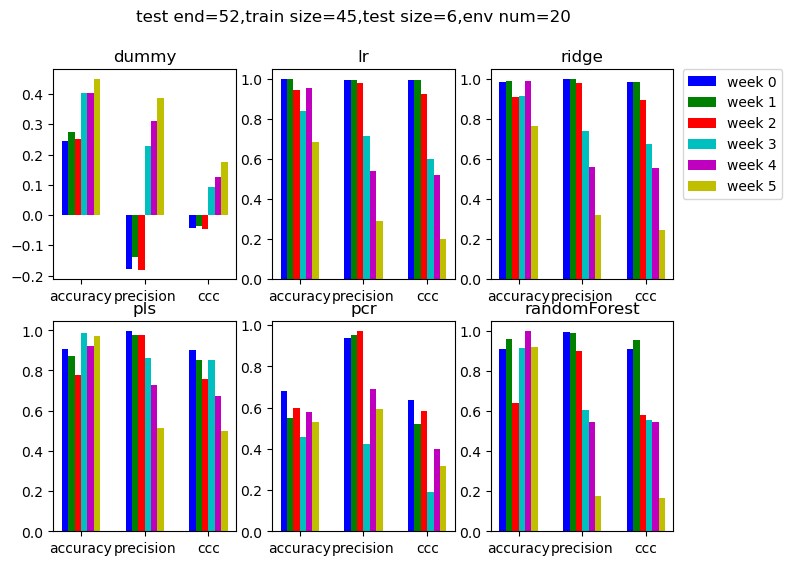

In [8]:
test_end,train_size,test_size,env_num=52,45,6,20
X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)

dummy=make_pipeline(DummyRegressor(strategy="mean"))
lr=make_pipeline(StandardScaler(),LinearRegression())
ridge=make_pipeline(StandardScaler(),Ridge())
pls=make_pipeline(StandardScaler(),PLSRegression(5))
pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
rf=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=0))
my=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),MyLinearRegression())


models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]
colors=['b','g','r','c','m','y']

# Compare the models
results = compare_models_timepoint(models, X_train, y_train, X_test, y_test)
timepoint=np.arange(y_test.shape[0])
# Print the results
n=0

fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for model, r2 in results.items():
    for time in timepoint:
        ax[n//3,n%3].bar(np.arange(3) + 0.1*time, r2[time][1:], color = colors[time],label='week '+str(time),width = 0.1)
        ax[n//3,n%3].set_title(model_name[n])
        ax[n//3,n%3].set_xticks(np.arange(3) + 0.1*2.5,['accuracy','precision','ccc'])
    n+=1
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.suptitle("test end="+str(test_end)+",train size="+str(train_size)+",test size="+str(test_size)+",env num="+str(env_num))
plt.savefig('image'+str(n)+'.png',bbox_inches='tight')


## Effect of train size 


In [9]:
test_end,test_size,env_num=52,6,20

pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]

train_size_c=[i for i in range(5,46,5)]
result_train_size={}

for train_size in train_size_c:
    X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
    r2 = list(compare_models_timepoint(models, X_train, y_train, X_test, y_test).values())[0]
    compare_models_output(models, model_name,envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num,filepath=outpath)
    result_train_size[train_size]=r2


C:\Users\10051\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 4
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Users\10051\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 4
  warnings.warn(f"Y residual is constant at iteration {k}")


Text(0.5, 0, 'data size of train set')

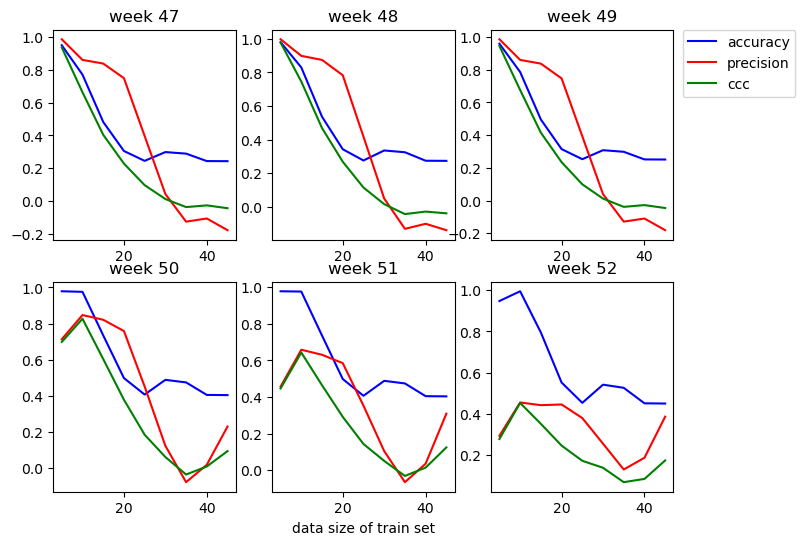

In [10]:
fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for time in range(0,6):
    accuracy=[result_train_size[train_size][time][1] for train_size in train_size_c]
    precision=[result_train_size[train_size][time][2] for train_size in train_size_c]
    ccc=[result_train_size[train_size][time][3] for train_size in train_size_c]
    ax[position[time][0],position[time][1]].plot(train_size_c,accuracy,color="b",label="accuracy")
    ax[position[time][0],position[time][1]].plot(train_size_c,precision,color="r",label="precision")
    ax[position[time][0],position[time][1]].plot(train_size_c,ccc,color="g",label="ccc")
    ax[position[time][0],position[time][1]].set_title('week '+str(time+47))
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('data size of train set')

## Effect of the range of test data

In [11]:
train_size,test_size,env_num=30,6,27

pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]

test_end_c=[i for i in range(36,53)]
result_test_end={}

for test_end in test_end_c:
    X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
    r2 = list(compare_models_timepoint(models, X_train, y_train, X_test, y_test).values())[0]
    compare_models_output(models, model_name,envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num,filepath=outpath)
    result_test_end[test_end]=r2


Text(0.5, 0, 'End of test data size')

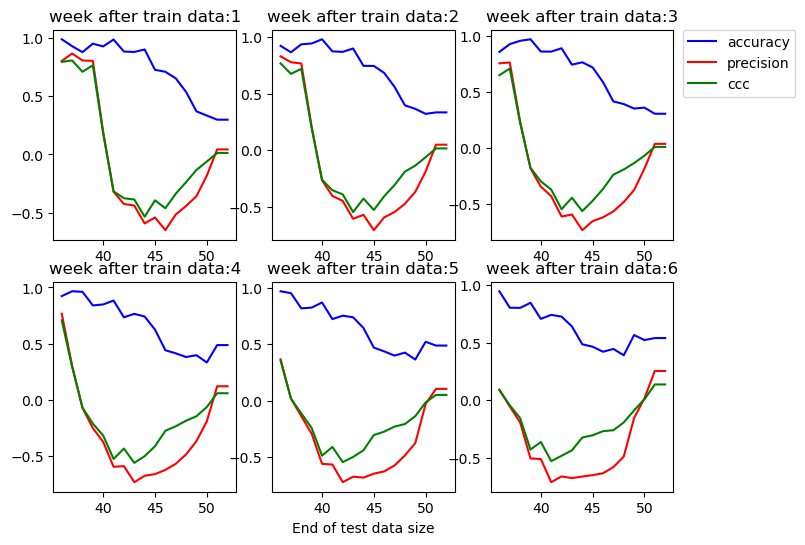

In [12]:
fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for time in range(0,6):
    accuracy=[result_test_end[test_end][time][1] for test_end in test_end_c]
    precision=[result_test_end[test_end][time][2] for test_end in test_end_c]
    ccc=[result_test_end[test_end][time][3] for test_end in test_end_c]
    ax[position[time][0],position[time][1]].plot(test_end_c,accuracy,color="b",label="accuracy")
    ax[position[time][0],position[time][1]].plot(test_end_c,precision,color="r",label="precision")
    ax[position[time][0],position[time][1]].plot(test_end_c,ccc,color="g",label="ccc")
    ax[position[time][0],position[time][1]].set_title('week after train data:'+str(time+1))
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('End of test data size')

## Effect of number of env variables

In [13]:
env1 = ["MLSS","Flowrate","Temp.AS","Days","SRT","DO","FM","Temp.Avg.WeekMean","COD.rmr",         "BOD.rmr","TN.rm","Precipitation.SamplingDate","Precipitation.MonthAccum","SVI",
         "TN.rmr","COD.rm","Precipitation.WeekMean","Temp.Avg.SamplingDate",
         "pH","NH4.rmr","BOD.rm","TP.rmr","Season","Precipitation.WeekAccum",
         "TP.rm","MLVSS","NH4.rm"]
env2 = ["FM","MLVSS","BOD.rmr","Season","DO","NH4.rmr",
         "Precipitation.WeekAccum","Flowrate","TN.rm",
         "TN.rmr","TP.rm","SRT","TP.rmr","COD.rm","BOD.rm",
         "Temp.Avg.WeekMean","Precipitation.WeekMean","MLSS",
         "COD.rmr","SVI","Precipitation.MonthAccum",
         "Temp.Avg.SamplingDate","Precipitation.SamplingDate","pH",
         "Days","Temp.AS","NH4.rm"]
env3 = ["MLSS","Temp.Avg.SamplingDate","FM",
         "NH4.rm","Days","MLVSS",
         "Precipitation.WeekAccum","TP.rm","Temp.Avg.WeekMean",
         "TN.rmr","SRT","SVI",
         "TN.rm","NH4.rmr","Precipitation.SamplingDate",
         "COD.rm","DO","COD.rmr","BOD.rmr","pH","Temp.AS",
         "Precipitation.MonthAccum","BOD.rm","TP.rmr",
         "Season","Precipitation.WeekMean","Flowrate"]

In [14]:
env=env[env1]
envnp1=env[env.columns[1:]].to_numpy(dtype='float32')

env=env[env2]
envnp2=env[env.columns[1:]].to_numpy(dtype='float32')

env=env[env3]
envnp3=env[env.columns[1:]].to_numpy(dtype='float32')

In [15]:
test_end,train_size,test_size=52,45,6
envnp=envnp3

pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]

env_num_c=[i for i in range(5,28)]
result_env_num={}

for env_num in env_num_c:
    X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
    r2 = list(compare_models_timepoint(models, X_train, y_train, X_test, y_test).values())[0]
    compare_models_output(models, model_name,envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num,filepath=outpath)
    result_env_num[env_num]=r2


Text(0.5, 0, 'Number of environmental factors')

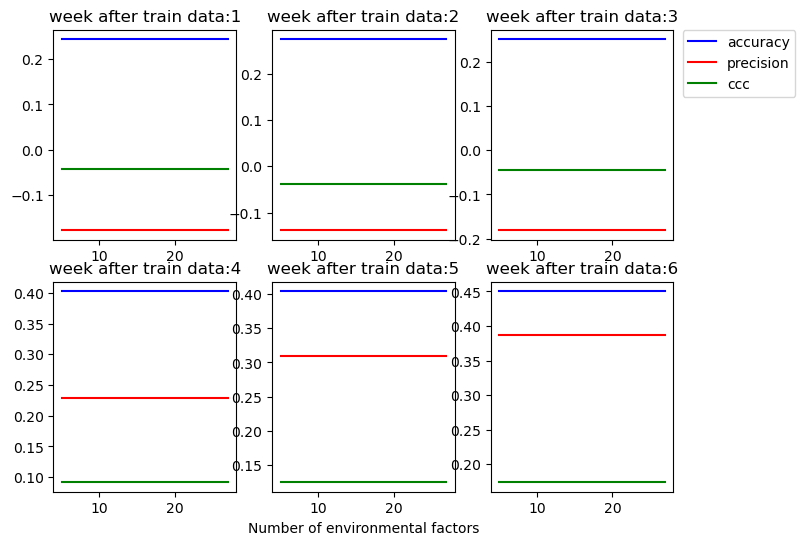

In [16]:
fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for time in range(0,6):
    accuracy=[result_env_num[env_num][time][1] for env_num in env_num_c]
    precision=[result_env_num[env_num][time][2] for env_num in env_num_c]
    ccc=[result_env_num[env_num][time][3] for env_num in env_num_c]
    ax[position[time][0],position[time][1]].plot(env_num_c,accuracy,color="b",label="accuracy")
    ax[position[time][0],position[time][1]].plot(env_num_c,precision,color="r",label="precision")
    ax[position[time][0],position[time][1]].plot(env_num_c,ccc,color="g",label="ccc")
    ax[position[time][0],position[time][1]].set_title('week after train data:'+str(time+1))
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of environmental factors')